# KZ NOTE:

    some more test of the architectures    

In [21]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d
from torchinfo import torchinfo

from compression_nn.preprocess import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16 #
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

In [6]:
# use only labels OMM, S8, w, A_IA, 

pars_train = pars_train[:, [0,1,3]]
pars_LFI = pars_LFI[:, [0,1,3]]



# Process data; with ZCA whitening

In [7]:
from compression_nn.preprocess import MinMaxNormalizer

In [8]:
print('Train with all 16 parameters.')

print('max-min normalize the labels')

# Initialize and fit normalizer
label_normalizer = MinMaxNormalizer()
pars_train = label_normalizer.fit_transform(pars_train)


Train with all 16 parameters.
max-min normalize the labels


In [9]:
num_samples = len(pars_train)
indices = np.random.permutation(num_samples)
train_size = int(0.9 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_loader, val_loader, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices],
    train_y=pars_train[train_indices],
    val_x=dv[val_indices],
    val_y=pars_train[val_indices],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening=True
)

In [10]:
train_loader

# Start Training!

In [24]:
hyperparameter_configs = [
    {
        'test_id': 'semi_ae_v1',
        'hidden_dims': [64, 32, 16],
        'dropout_rate': 0.1
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.ReLU(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=50,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [03:35<02:54,  1.30s/it]

Epoch 166/300:
Training Loss: 0.064567
Validation Loss: 0.058251


 60%|██████    | 181/300 [03:55<02:35,  1.31s/it]

Epoch 181/300:
Training Loss: 0.064399
Validation Loss: 0.065249


 65%|██████▌   | 196/300 [04:14<02:16,  1.31s/it]

Epoch 196/300:
Training Loss: 0.065079
Validation Loss: 0.064089


 69%|██████▉   | 208/300 [04:31<02:00,  1.31s/it]

Early stopping triggered after 209 epochs
Best validation loss is 0.05752733375491767
Model and preprocessing saved to models/model_semi_ae_v1.pkl


In [25]:
# torchinfo.summary(model.model, input_size=(BATCH_SIZE, train_loader.dataset.tensors[0].shape[1]),
#                  col_names=["input_size", "output_size", "num_params", "kernel_size"],
#                  depth=2)

In [30]:
hyperparameter_configs = [
    {
        'test_id': 'semi_ae_v2',
        'hidden_dims': [64, 64, 64, 64],
        'dropout_rate': 0.1
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.ReLU(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=50,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [03:44<03:00,  1.35s/it]

Epoch 166/300:
Training Loss: 0.067195
Validation Loss: 0.060717


 60%|██████    | 181/300 [04:04<02:38,  1.33s/it]

Epoch 181/300:
Training Loss: 0.066168
Validation Loss: 0.060213


 65%|██████▌   | 196/300 [04:25<02:20,  1.35s/it]

Epoch 196/300:
Training Loss: 0.066663
Validation Loss: 0.062971


 70%|███████   | 211/300 [04:45<02:02,  1.38s/it]

Epoch 211/300:
Training Loss: 0.066035
Validation Loss: 0.137718


 75%|███████▌  | 226/300 [05:06<01:42,  1.39s/it]

Epoch 226/300:
Training Loss: 0.066566
Validation Loss: 0.060116


 80%|████████  | 241/300 [05:26<01:20,  1.36s/it]

Epoch 241/300:
Training Loss: 0.066299
Validation Loss: 0.061165


 85%|████████▌ | 256/300 [05:47<01:00,  1.38s/it]

Epoch 256/300:
Training Loss: 0.065941
Validation Loss: 0.062275


 90%|█████████ | 271/300 [06:08<00:41,  1.42s/it]

Epoch 271/300:
Training Loss: 0.066747
Validation Loss: 0.061421


 95%|█████████▌| 286/300 [06:28<00:18,  1.35s/it]

Epoch 286/300:
Training Loss: 0.065922
Validation Loss: 0.113556


100%|██████████| 300/300 [06:47<00:00,  1.36s/it]

Model and preprocessing saved to models/model_semi_ae_v2.pkl


In [31]:
# torchinfo.summary(model.model, input_size=(BATCH_SIZE, train_loader.dataset.tensors[0].shape[1]),
#                  col_names=["input_size", "output_size", "num_params", "kernel_size"],
#                  depth=2)

In [32]:
hyperparameter_configs = [
    {
        'test_id': 'semi_ae_v3',
        'hidden_dims': [64, 64, 64, 64, 16],
        'dropout_rate': 0.1
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader.dataset.tensors[0].shape[1],
        output_dim=train_loader.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.ReLU(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=NUM_EPOCH,
        early_stopping_patience=50,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [04:33<03:51,  1.73s/it]

Epoch 166/300:
Training Loss: 0.067670
Validation Loss: 0.061994


 60%|██████    | 181/300 [04:58<03:13,  1.63s/it]

Epoch 181/300:
Training Loss: 0.067791
Validation Loss: 0.059606


 65%|██████▌   | 196/300 [05:23<02:53,  1.67s/it]

Epoch 196/300:
Training Loss: 0.068974
Validation Loss: 0.060767


 70%|███████   | 211/300 [05:48<02:27,  1.66s/it]

Epoch 211/300:
Training Loss: 0.068153
Validation Loss: 0.060661


 75%|███████▌  | 226/300 [06:13<02:02,  1.65s/it]

Epoch 226/300:
Training Loss: 0.067307
Validation Loss: 0.059281


 80%|████████  | 241/300 [06:38<01:38,  1.67s/it]

Epoch 241/300:
Training Loss: 0.067927
Validation Loss: 0.062455


 84%|████████▍ | 252/300 [06:58<01:19,  1.66s/it]

Early stopping triggered after 253 epochs
Best validation loss is 0.058613508554368185
Model and preprocessing saved to models/model_semi_ae_v3.pkl


# plot validations

In [33]:
from compression_nn.utils import plot_test_error

In [34]:
def plot_test_error_all_param_TEST(model, test_loader, n_params, label_normalizer=None, device='cuda', output=False, out_name='test', Y_min=0, Y_max=1, color='steelblue'):

    g=range(n_params)

    test_loss1, test_loss2 = torch.zeros(len(g)).to(device), torch.zeros(len(g)).to(device)
    points = 0

    ## Model performance metrics on test set
    num_maps=test_loader.dataset.tensors[0].shape[0]

    # define the arrays containing the value of the parameters
    params_true = np.zeros((num_maps,len(g)), dtype=np.float32)
    params_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)
    errors_NN   = np.zeros((num_maps,len(g)), dtype=np.float32)

    # model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            bs    = x.shape[0]         #batch size
            if x.dtype == torch.float64:
                x = x.float()
            x     = x.to(device)       #send data to device
            y     = y.to(device)  #send data to device
            p     = model.predict(x)           #prediction for mean and variance
            y_NN  = p           #prediction for mean

            # save results to their corresponding arrays
            params_true[points:points+x.shape[0]] = y.cpu().numpy()
            if isinstance(y_NN, torch.Tensor):
                y_NN = y_NN.cpu().numpy()
            params_NN[points:points+x.shape[0]]   = y_NN

            points    += x.shape[0]
            
    # inverse-normalization if needed
    if label_normalizer is not None:
        params_NN   = label_normalizer.inverse_transform(params_NN)

    test_error = 100*np.mean(np.sqrt((params_true - params_NN)**2)/params_true,axis=0)
    
    RMSE = np.sqrt(np.mean((params_true - params_NN)**2,axis=0))
    RMSE_P = RMSE*100
    params_true_mean = np.mean(params_true)
    tmp = np.mean((params_true - params_true_mean)**2, axis=0)
    R2 = 1 - (RMSE)**2 / tmp
    # print('Error Omega_m = %.3f'%test_error[0])
    print(r' RMSE = %.3f'%RMSE[0])
    print(r' $R^2$ = %.3f'%R2[0])
    print('Error S_8 = %.3f'%test_error[0])

    # KZ: let me first assume n_params is even 
    f, axarr = plt.subplots(1, 3, figsize=(20,10))
    
    for i in range(n_params):
        # if i%2==0:
        row_idx = i
        print('test', i)
        axarr[row_idx].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

        axarr[row_idx].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
        axarr[row_idx].set_xlabel(r"True param "+str(i))
        axarr[row_idx].set_ylabel(r"Predicted param "+ str(i))

        axarr[row_idx].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx].transAxes)
        axarr[row_idx].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx].transAxes)

#         else:
#             row_idx = i//2
            
#             axarr[row_idx,1].plot(np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),np.linspace(min(params_true[:,i]),max(params_true[:,i]),100),color="black")

#             axarr[row_idx,1].plot(params_true[:,i],params_NN[:,i],marker="o",ls="none",markersize=2, color=color)
#             axarr[row_idx,1].set_xlabel(r"True param "+str(i))
#             axarr[row_idx,1].set_ylabel(r"Predicted param "+ str(i))

#             axarr[row_idx,1].text(0.08,0.9,r"RMSE = %.3f %% " % RMSE_P[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
#             axarr[row_idx,1].text(0.08,0.82,r"$R^2$ = %.3f" % R2[i],fontsize=12,transform=axarr[row_idx,1].transAxes)
            
    if output:
        f.savefig('./output/'+out_name+'.pdf', dpi=300, format='pdf')

        # Also save for LFI later
        info = dict()
        info['params'] = params_true
        info['compressed_DV'] = params_NN
        np.save('./output/'+out_name+'_compressed_dv',info)

 RMSE = 0.036
 $R^2$ = 0.974
Error S_8 = 8.218
test 0
test 1
test 2


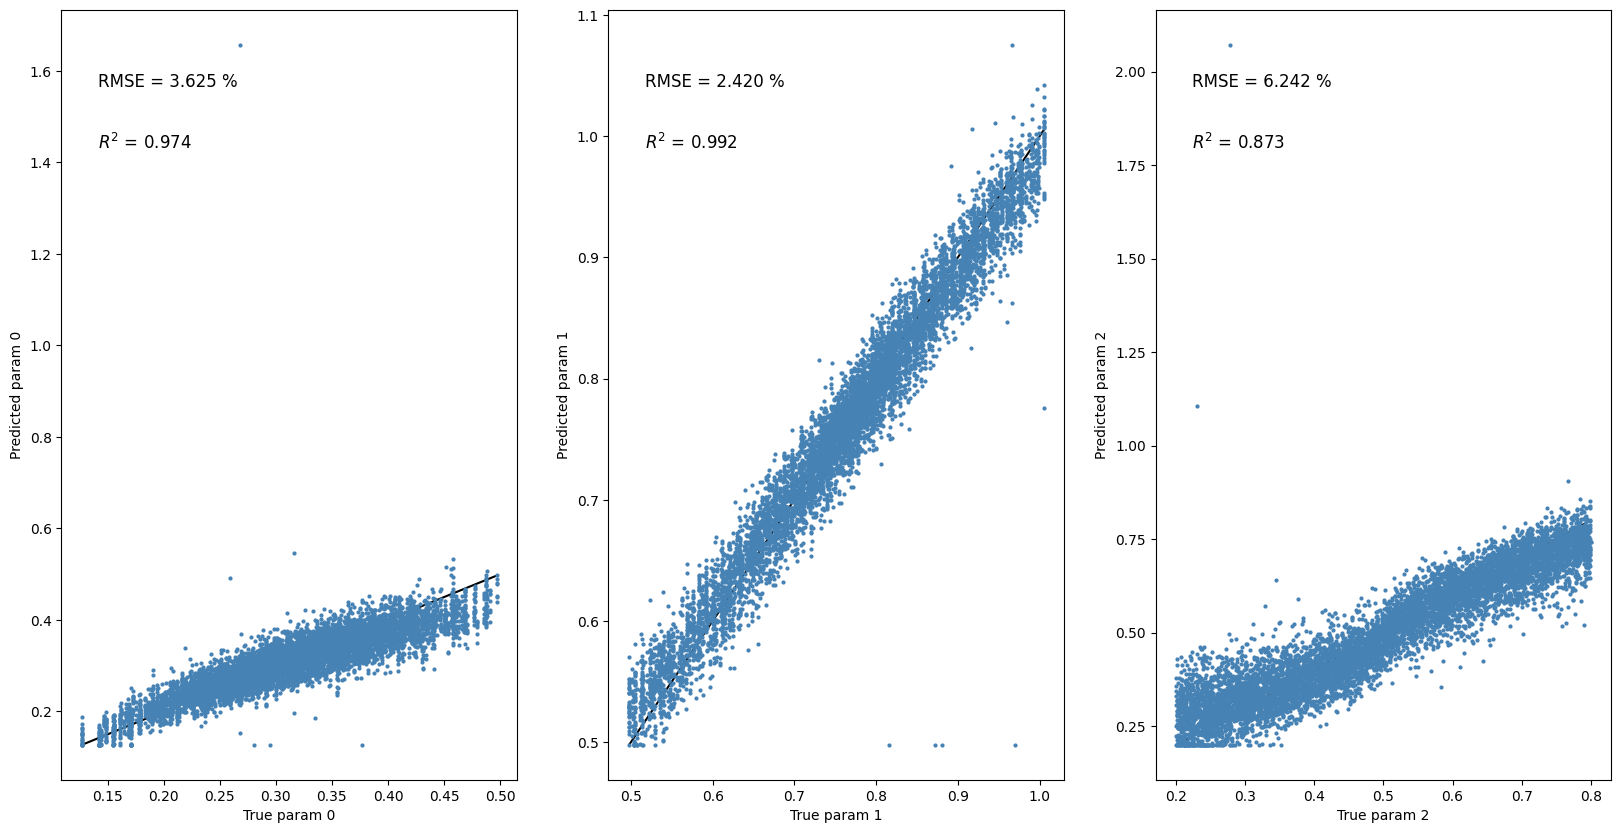

In [35]:
loaded_model = CompressionNN.load('semi_ae_v1')
loaded_model.model.to('cpu')

plot_test_error_all_param_TEST(loaded_model, test_loader, n_params=3, label_normalizer=label_normalizer, device='cpu', output=False)


 RMSE = 0.042
 $R^2$ = 0.966
Error S_8 = 8.483
test 0
test 1
test 2


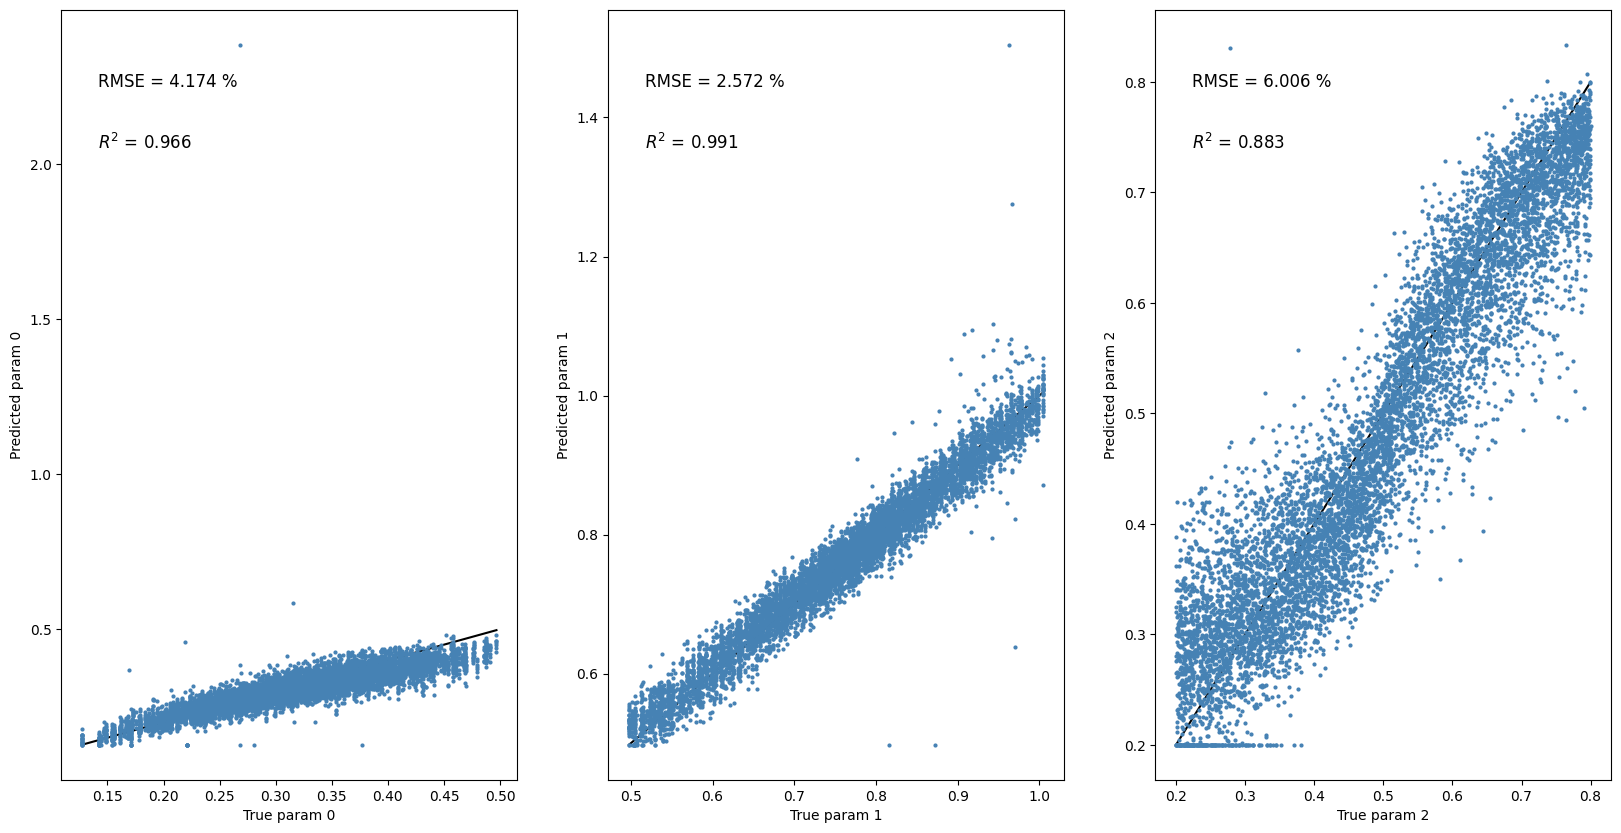

In [46]:
loaded_model = CompressionNN.load('semi_ae_v2')
loaded_model.model.to('cpu')

plot_test_error_all_param_TEST(loaded_model, test_loader, n_params=3, label_normalizer=label_normalizer, device='cpu', output=False)


In [47]:
test_full_dv = test_loader.dataset.tensors[0]
print(test_full_dv.shape)

torch.Size([8187, 608])


In [48]:
compressed_dv_semi_ae = loaded_model.get_last_hidden_layer(test_full_dv)


(-20.0, 10.0)

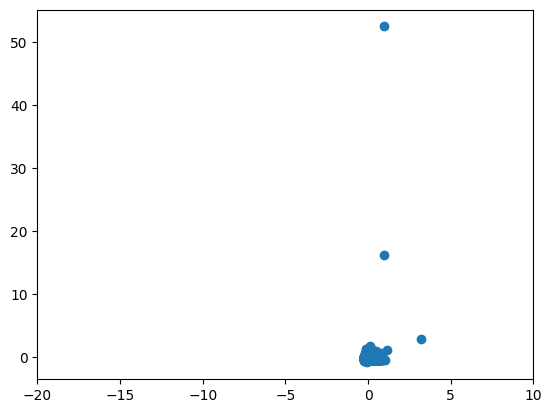

In [49]:
plt.scatter(compressed_dv_semi_ae[:,0], compressed_dv_semi_ae[:,1])
plt.xlim(-20,10)

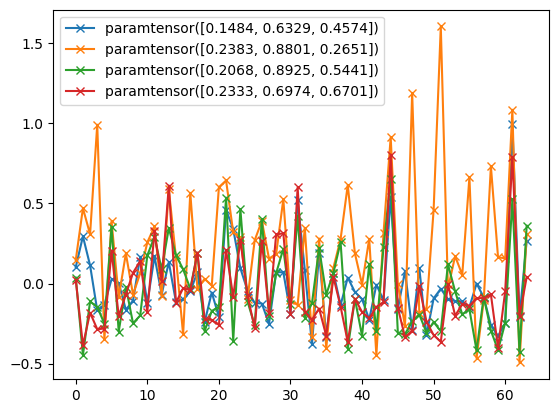

In [50]:
for i in [1,5,200,100]:
    plt.plot(compressed_dv_semi_ae[i], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
    
plt.legend()

# Test at fiducial cosmology

In [64]:
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()

dv_set_fid = derivatives_dict['WL_23_WPH_WCMBL_CMBL']['cov'][:,indict2['WL_23_WPH_short_CMBWL'] ]

dv_compressed_fid = loaded_model.predict(dv_set_fid)
dv_compressed_fid = label_normalizer.inverse_transform(dv_compressed_fid)

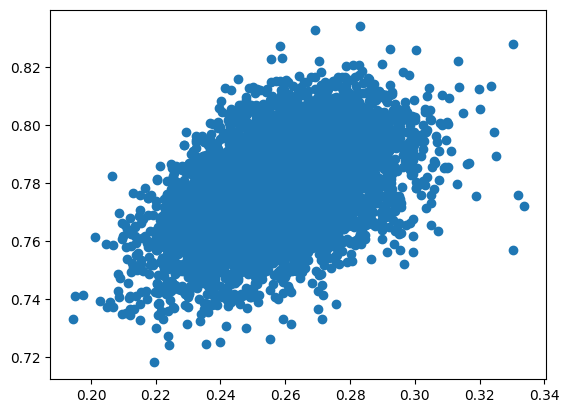

In [65]:
plt.scatter(dv_compressed_fid[:,0], dv_compressed_fid[:,1])

In [53]:
target_compressed_dv = np.mean(dv_compressed_fid, axis=0)

In [63]:
dv_compressed_fid.shape

(6400, 3)

In [54]:
dv_compressed_fid_ae = loaded_model.get_last_hidden_layer(dv_set_fid)
dv_compressed_fid_ae = np.mean(dv_compressed_fid_ae,axis=0)

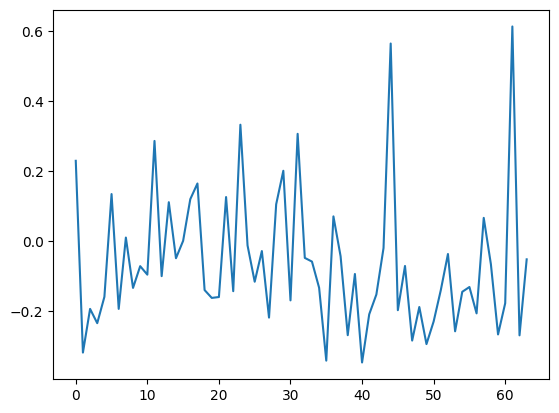

In [55]:

plt.plot(dv_compressed_fid_ae)

In [56]:
compressed_dv_semi_ae.shape, dv_compressed_fid_ae.shape

((8187, 64), (64,))

In [57]:
np.save('./output/compressed_dv_semi_ae_d64', compressed_dv_semi_ae)
np.save('./output/dv_compressed_fid_ae_d64', dv_compressed_fid_ae)

# Perform PCA on these 64 down to 16

In [66]:
compressed_dv_semi_ae.shape, loaded_model.get_last_hidden_layer(dv_set_fid).shape

((8187, 64), (6400, 64))

In [60]:
def fit_pca(data, n_components=16):
    """
    Fit PCA and return components and mean for later use.
    """
    # Compute mean
    data_mean = np.mean(data, axis=0)
    
    # Center the data
    data_centered = data - data_mean
    
    # Compute covariance matrix
    cov_matrix = np.cov(data_centered, rowvar=False)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select top n_components
    components = eigenvectors[:, :n_components]
    
    # Save components and mean
    np.savez('pca_params.npz', 
             components=components,
             data_mean=data_mean,
             explained_variance=eigenvalues[:n_components])
    
    return components, data_mean, eigenvalues[:n_components]

def transform_with_pca(new_data, components=None, data_mean=None):
    """
    Transform new data using saved PCA parameters.
    If components and data_mean are not provided, load from file.
    """
    if components is None or data_mean is None:
        # Load saved parameters
        loaded = np.load('pca_params.npz')
        components = loaded['components']
        data_mean = loaded['data_mean']
    
    # Center the data using saved mean
    data_centered = new_data - data_mean
    
    # Project data onto principal components
    transformed_data = np.dot(data_centered, components)
    
    return transformed_data

In [77]:
# Generate sample training data
np.random.seed(42)

# Fit PCA and save parameters
components, data_mean, explained_variance = fit_pca(compressed_dv_semi_ae, n_components=16)
print("PCA parameters saved to 'pca_params.npz'")

# Generate sample test data
test_data = loaded_model.get_last_hidden_layer(dv_set_fid)  # Different number of samples, same features

# Method 1: Transform using loaded parameters
transformed_test1 = transform_with_pca(compressed_dv_semi_ae)  # Loads from file

# Method 2: Transform using parameters in memory
transformed_test2 = transform_with_pca(compressed_dv_semi_ae, components, data_mean)


test_data_compressed = transform_with_pca(test_data, components, data_mean)


print(f"\nOriginal test data shape: {test_data.shape}")
print(f"Transformed test data shape: {transformed_test1.shape}")

# Verify both methods give same results
print(f"Methods 1 and 2 give identical results: {np.allclose(transformed_test1, transformed_test2)}")


PCA parameters saved to 'pca_params.npz'

Original test data shape: (6400, 64)
Transformed test data shape: (8187, 16)
Methods 1 and 2 give identical results: True


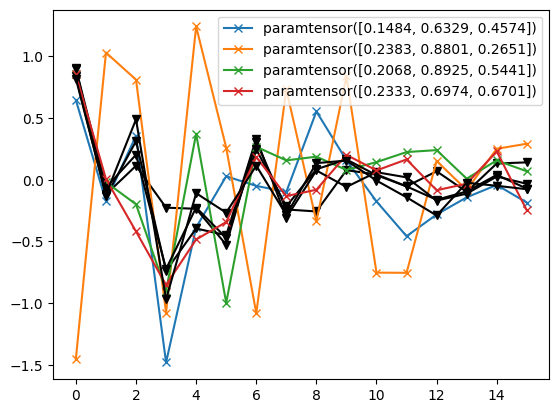

In [78]:
for i in [1,5,200,100]:
    plt.plot(transformed_test1[i], 'x-', label='param'+str(test_loader.dataset.tensors[1][i]))
    plt.plot(test_data_compressed[i], 'v-', c='black')
plt.legend()

In [79]:
transformed_test1.shape, test_data_compressed.shape

((8187, 16), (6400, 16))

In [80]:
np.save('./output/compressed_dv_semi_ae_d64_pca16', transformed_test1)
np.save('./output/dv_compressed_fid_ae_d64_pca16', np.mean(test_data_compressed,axis=0))